## Some Review!!

1. Self-Attention Layer Advantage: parallel computation
2. query, key, value interactions
3. Positional Encoding
4. Decoder has some properties just like RNN

#### [References](https://leemeng.tw/neural-machine-translation-with-transformer-and-tensorflow2.html)

## Prepare Dataset

In [103]:
## package used
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint ## print beautifully
 
import tensorflow as tf
import tensorflow_datasets as tfds

In [104]:
## !pip install tensorflow-gpu == 2.0.0-beta0

In [105]:
## make tensorflow not that annoying
import logging
logging.basicConfig(level = 40)

## make numpy show numbers that are more intuitive
np.set_printoptions(suppress = True)

In [106]:
output_dir = "Trans"
if output_dir not in os.listdir():
    os.makedirs(output_dir) ## make the dir

## define path that we are going to store

en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

In [107]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets) ## dataset avaliable for zh_en

{Split('train'): ['newscommentary_v14',
                  'wikititles_v1',
                  'uncorpus_v1',
                  'casia2015',
                  'casict2011',
                  'casict2015',
                  'datum2015',
                  'datum2017',
                  'neu2017'],
 Split('validation'): ['newstest2018']}


#### [TFDS_API](https://www.tensorflow.org/datasets/catalog/overview#translate)


In [108]:
config = tfds.translate.wmt.WmtConfig(
            version=tfds.core.Version("1.0.0"),
            language_pair=("zh", "en"),
            subsets={
                tfds.Split.TRAIN: ["newscommentary_v14"]
            }
        )
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)

## ther so miuch warning are actually helping us get rid of abnormal format of data

In [109]:
## data are too big, just use a few of them
split = ['train[:20%]', 'train[20%:21%]']
train_examples, val_examples = builder.as_dataset(split=split, as_supervised=True)

In [110]:
## take a peak of it
for en, zh in train_examples.take(1):
    print(en)
    print()
    print(zh)
    print()

tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)

tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)



In [111]:
## what the f*ck is that? That us decode it out

sample = []
num_sample = 1

for en, zh in train_examples.take(3):
    en = en.numpy().decode("utf-8")
    zh = zh.numpy().decode("utf-8")
    
    print(en)
    print(zh)
    print()

The fear is real and visceral, and politicians ignore it at their peril.
这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。

In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word “liberal” – a champion of the cause of individual freedom.
事实上，德国政治局势需要的不过是一个符合美国所谓“自由”定义的真正的自由党派，也就是个人自由事业的倡导者。

Shifting to renewable-energy sources will require enormous effort and major infrastructure investment.
必须付出巨大的努力和基础设施投资才能完成向可再生能源的过渡。



In [112]:
## create bag of words index dict

## use the wordpieces model (GNMT)
try:
    ## next time we will just read the "bags"
    subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
except:

    subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (en.numpy() for en, _ in train_examples), target_vocab_size=2**13)

    # save ur result for next used
    subword_encoder_en.save_to_file(en_vocab_file)

    print(f"size of bags：{subword_encoder_en.vocab_size}")
    print(f"examples：{subword_encoder_en.subwords[:10]}")



In [113]:
## try it?
sample_sentence = "I am a pig"
indices = subword_encoder_en.encode(sample_sentence)

print(indices)

[125, 1558, 8, 1166, 7960]


In [114]:
## back?

sample_sentence = []
for idx in indices:
    subwords = subword_encoder_en.decode([idx])
    sample_sentence.append(subwords)
    
print(sample_sentence)

## words that never appear in the corpus will be deconstructed
## this kind of word to poeces method are more flexible while facing unseen words

## decode and encode just works like an 1-1 function

['I ', 'am ', 'a ', 'pi', 'g']


In [115]:
## time for zh

try:
    ## next time we will just read the "bags"
    subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
except:


    subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (zh.numpy() for _, zh in train_examples), target_vocab_size=2**13,
            max_subword_length = 1 ## zh doesnot have more than one subword
    )

    # save ur result for next used
    subword_encoder_zh.save_to_file(zh_vocab_file)

    print(f"size of bags：{subword_encoder_zh.vocab_size}")
    print(f"examples：{subword_encoder_zh.subwords[:10]}")

In [116]:
## 這句話沒辦法翻譯我打中文
## 可悲沒有繁體字

## similarly, we sample to check 1-1 propeties

sample_sentence = "我是一只猪"
indices = subword_encoder_zh.encode(sample_sentence)
print(indices)

sample_sentence = []
for idx in indices:
    subwords = subword_encoder_zh.decode([idx])
    sample_sentence.append(subwords)
    
print(sample_sentence)

[65, 6, 7, 223, 2078]
['我', '是', '一', '只', '猪']


In [117]:
## concate above, we now have
sample_sent_en = "I am a pig"
sample_sent_zh = "我是一只猪"

indice_en = subword_encoder_en.encode(sample_sent_en)
indice_zh = subword_encoder_zh.encode(sample_sent_zh)

print("Before:")
print(sample_sent_en)
print(sample_sent_zh)
print()
print("After:")
print(indice_en)
print(indice_zh)


Before:
I am a pig
我是一只猪

After:
[125, 1558, 8, 1166, 7960]
[65, 6, 7, 223, 2078]


In [118]:
## adding token representing the start and end, <BOS> and <EOS>

## input -> two string temsor
## output -> two indices with BOS,EOS
def encode(en_t, zh_t):
    en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
    en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
    
    zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
    zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
    
    return en_indices, zh_indices


In [119]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)

print('en BOS index：', subword_encoder_en.vocab_size)
print('en EOS index：', subword_encoder_en.vocab_size + 1)
print('zh BOS index：', subword_encoder_zh.vocab_size)
print('zh EOS index：', subword_encoder_zh.vocab_size + 1)
print()
print(en_t.numpy())
print(zh_t.numpy())
print()
print(en_indices)
print(zh_indices)

en BOS index： 8113
en EOS index： 8114
zh BOS index： 4205
zh EOS index： 4206

b'The fear is real and visceral, and politicians ignore it at their peril.'
b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82'

[8113, 16, 1284, 9, 243, 5, 1275, 1756, 156, 1, 5, 1016, 5566, 21, 38, 33, 2982, 7965, 7903, 8114]
[4205, 10, 151, 574, 1298, 6, 374, 55, 29, 193, 5, 1, 3, 3981, 931, 431, 125, 1, 17, 124, 33, 20, 97, 1089, 1247, 861, 3, 4206]


In [120]:
## but, we cannot use it directly to our dataset because tf functions are graph mode
## does not have numpy

## def new one for tf

def tf_encode(en_t, zh_t):
    return tf.py_function(encode, [en_t,zh_t], [tf.int64, tf.int64])

In [121]:
## what we done?
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))

print(en_indices)
print()
print(zh_indices)

## tmp outputs two indices

tf.Tensor(
[8113   16 1284    9  243    5 1275 1756  156    1    5 1016 5566   21
   38   33 2982 7965 7903 8114], shape=(20,), dtype=int64)

tf.Tensor(
[4205   10  151  574 1298    6  374   55   29  193    5    1    3 3981
  931  431  125    1   17  124   33   20   97 1089 1247  861    3 4206], shape=(28,), dtype=int64)


In [122]:
## in order to speed up ! remove all sentence has 40 ups indices

MAX_LENGTH = 40

def filter_max_length(en, zh, max_length = MAX_LENGTH):
    ## return TRUE, FALSE
    return tf.logical_and(tf.size(en) <= max_length,tf.size(zh) <= max_length)

## return TRUE values
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [123]:
num_examples = 0

## use for, but not recommanded
for en_indices, zh_indices in tmp_dataset:
    cond1  = len(en_indices) <= MAX_LENGTH
    cond2 = len(zh_indices) <= MAX_LENGTH
    
    assert cond1 and cond2
    num_examples += 1

print(f"we have {num_examples} data below {MAX_LENGTH} tokens")

we have 29784 data below 40 tokens


In [124]:
## cuz our data has different length, building batch may occur some errors
## padding as we do in image

BATCH_SIZE = 64
## padding to be the same length
## padding as same length to the longest length
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("en indices batch")
print(en_batch)
print()
print("zh indicesbatch")
print(zh_batch)

en indices batch
tf.Tensor(
[[8113   16 1284 ...    0    0    0]
 [8113 1894 1302 ...    0    0    0]
 [8113   44   40 ...    0    0    0]
 ...
 [8113  122  506 ...    0    0    0]
 [8113   16  215 ...    0    0    0]
 [8113 7443 7889 ...    0    0    0]], shape=(64, 39), dtype=int64)

zh indicesbatch
tf.Tensor(
[[4205   10  151 ...    0    0    0]
 [4205  206  275 ...    0    0    0]
 [4205    5   10 ...    0    0    0]
 ...
 [4205   34    6 ...    0    0    0]
 [4205  317  256 ...    0    0    0]
 [4205  167  326 ...    0    0    0]], shape=(64, 40), dtype=int64)


In [125]:
## combine above all to create out train and valid
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

train_dataset = (train_examples  
                 .map(tf_encode) 
                 .filter(filter_max_length)
                 .cache() # speed up reading 
                 .shuffle(BUFFER_SIZE) # break origin order
                 .padded_batch(BATCH_SIZE, 
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # speed up

val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

## cache and AUTOTUNE
## https://www.tensorflow.org/guide/data_performance?hl=zh_cn


In [126]:
## take a peak and inagime what's going on!

en_batch, zh_batch = next(iter(train_dataset)) ##return in one batch
print("en indices batch")
print(en_batch)
print()
print("zh indices batch")
print(zh_batch)

en indices batch
tf.Tensor(
[[8113   16 1547 ...    0    0    0]
 [8113   87    9 ...    0    0    0]
 [8113 1636   54 ...    0    0    0]
 ...
 [8113   87 5185 ...    0    0    0]
 [8113 7646 2120 ...    0    0    0]
 [8113  624    7 ...    0    0    0]], shape=(128, 39), dtype=int64)

zh indices batch
tf.Tensor(
[[4205  201  160 ...    0    0    0]
 [4205   30    4 ...    0    0    0]
 [4205  286   12 ...    0    0    0]
 ...
 [4205   10  269 ...    0    0    0]
 [4205   34    6 ...    0    0    0]
 [4205    7   66 ...    0    0    0]], shape=(128, 40), dtype=int64)


## Prepare Model

In [127]:
## To help us into tensorflow world
## make some examples to track!

demo_examples = [
    ("I am a pig","我是一只猪"),
    ("The numbers speak for themselves.", "数字证明了一切。")    
]

print(demo_examples)

[('I am a pig', '我是一只猪'), ('The numbers speak for themselves.', '数字证明了一切。')]


In [128]:
batch_size = 2
## make it to tensor
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

In [129]:
## same as above procedure
demo_dataset = demo_examples.map(tf_encode).padded_batch(batch_size, padded_shapes=([-1], [-1]))
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print()
print('tar:', tar)

## shape = (batch_size, max_length)

inp: tf.Tensor(
[[8113  125 1558    8 1166 7960 8114    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4205   65    6    7  223 2078 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)


In [130]:
## First! do word embedding

vocab_size_en = subword_encoder_en.vocab_size + 2 ## plus BOS, EOS
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# to 4 dim
## random vectors for before-training
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
 array([[[-0.03639312, -0.02757695,  0.04359658, -0.03537921],
         [ 0.01971773, -0.0400288 , -0.03068806,  0.00325962],
         [ 0.02722507, -0.02708452,  0.03049209, -0.02288125],
         [-0.03032577, -0.0354887 ,  0.03697484,  0.02999594],
         [ 0.01879238,  0.02930457,  0.04095887, -0.04010413],
         [ 0.03148792, -0.02128877, -0.02220495,  0.01309374],
         [-0.00649624, -0.02425881, -0.04920071,  0.04663258],
         [ 0.04220078,  0.02385452, -0.04670385,  0.04206574]],
 
        [[-0.03639312, -0.02757695,  0.04359658, -0.03537921],
         [-0.03799623,  0.00689935,  0.02657298, -0.04832831],
         [ 0.019558  ,  0.00797454, -0.02867308,  0.01105939],
         [ 0.02977253,  0.02150572, -0.02371547,  0.02535402],
         [ 0.0018843 ,  0.0083848 , -0.01313395, -0.04100952],
         [-0.03851343, -0.00084137,  0.00652003,  0.03005591],
         [-0.0193126 , -0.02821339, -0.03997569, -0.0069155 ],


In [131]:
## Masking
## include two part
## one is inside the decoder, another is for padding
## mask the padding because it's meaningless

def create_padding_mask(seq):
    mask = tf.cast(tf.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] ## we will use it after, for broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [132]:
print("inp:", inp)
print()
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

## we can just mask the 1 part

inp: tf.Tensor(
[[8113  125 1558    8 1166 7960 8114    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)



<img src="scale_dot.png" width="40%">

In [133]:
## scale dot attention

def scaled_dot_product_attention(q, k, v, mask):
  
    matmul_qk = tf.matmul(q, k, transpose_b=True) ## matrix mutiplication
    dk = tf.cast(tf.shape(k)[-1], tf.float32) ## len of seq
    
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) 
    
    ## masking
    if mask is not None: ## which means has 1
        scaled_attention_logits += (mask * -1e9) 
        ## paper denote as negative infinite
        ## we just add a really big negative number

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
      
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [134]:
## decoder mask
def create_look_ahead_mask(size):
    mask = 1-tf.linalg.band_part(tf.ones((size, size)), -1, 0) ##Upper right triangle has value
    return mask

seq_len = emb_tar.shape[1]
look_ahead_mask = create_look_ahead_mask(seq_len)

print(look_ahead_mask)

tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


In [135]:
temp_q = temp_k = emb_tar

temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

## print out! we can see that in a sentence, the word only attention words before
## 我畫個方格圖讓大家了解！
## row col 都是 我是一隻豬

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.4997743  0.50022566 0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.3328728  0.3333655  0.3337617  0.         0.         0.
   0.         0.         0.         0.        ]
  [0.24975398 0.24988763 0.25015718 0.2502012  0.         0.
   0.         0.         0.         0.        ]
  [0.1999227  0.1999792  0.1999567  0.19990727 0.20023407 0.
   0.         0.         0.         0.        ]
  [0.16675764 0.16664171 0.16652788 0.16648448 0.16677557 0.16681276
   0.         0.         0.         0.        ]
  [0.14302464 0.14282268 0.14256084 0.14261211 0.14284477 0.14296679
   0.14316817 0.         0.         0.        ]
  [0.125028   0.12489291 0.12495697 0.12507041 0.12497041 0.12497012
   0.12496808 0.12514313 0.         0.        ]
  [0.11112186 0.1110018  0.11105873 0.11115956 0.11107069 0.11107042
   0.

<img src="mutihead.png" width="40%">

In [136]:
## multi-head attetion
## just like considering different aspects, like grammar, syntax.....

def split_heads(x, d_model, num_heads):
    ## x.shape: (batch_size, seq_len, d_model)
    batch_size = tf.shape(x)[0]
  
    assert d_model % num_heads == 0 ## ensure the division
    depth = d_model // num_heads  ## dim of each head
    
    ## num_heads * depth = d_model, split the origin 
    reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
    
    ## change dim
    ## (batch_size, num_heads, seq_len, depth)
    output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
    return output

In [137]:
## take a peak!
d_model = 4
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("output:", output)

output: tf.Tensor(
[[[[-0.03639312 -0.02757695]
   [ 0.01971773 -0.0400288 ]
   [ 0.02722507 -0.02708452]
   [-0.03032577 -0.0354887 ]
   [ 0.01879238  0.02930457]
   [ 0.03148792 -0.02128877]
   [-0.00649624 -0.02425881]
   [ 0.04220078  0.02385452]]

  [[ 0.04359658 -0.03537921]
   [-0.03068806  0.00325962]
   [ 0.03049209 -0.02288125]
   [ 0.03697484  0.02999594]
   [ 0.04095887 -0.04010413]
   [-0.02220495  0.01309374]
   [-0.04920071  0.04663258]
   [-0.04670385  0.04206574]]]


 [[[-0.03639312 -0.02757695]
   [-0.03799623  0.00689935]
   [ 0.019558    0.00797454]
   [ 0.02977253  0.02150572]
   [ 0.0018843   0.0083848 ]
   [-0.03851343 -0.00084137]
   [-0.0193126  -0.02821339]
   [-0.00649624 -0.02425881]]

  [[ 0.04359658 -0.03537921]
   [ 0.02657298 -0.04832831]
   [-0.02867308  0.01105939]
   [-0.02371547  0.02535402]
   [-0.01313395 -0.04100952]
   [ 0.00652003  0.03005591]
   [-0.03997569 -0.0069155 ]
   [-0.04920071  0.04663258]]]], shape=(2, 2, 8, 2), dtype=float32)


In [138]:
class MultiHeadAttention(tf.keras.layers.Layer):
    ## some variables we r going to use
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads 
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0 
    
        self.depth = d_model // self.num_heads 
    
        ## the linear transformation for qkv
        self.wq = tf.keras.layers.Dense(d_model)  
        self.wk = tf.keras.layers.Dense(d_model)  
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model) 
  

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
  
  
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  
        k = self.wk(k) 
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        ## concat, combining the heads
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) 
        output = self.dense(concat_attention)
        
        return output, attention_weights

<img src="model_all.png" width="40%">

In [139]:
## feed forward network
def point_wise_feed_forward_network(d_model, dff):
    
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model) 
    ])

In [140]:
## Encoder layer
class EncoderLayer(tf.keras.layers.Layer):
  ## dropout rate = 0.1
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, attn = self.mha(x, x, x, mask)  
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(x + attn_output)  

        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
        out2 = self.layernorm2(out1 + ffn_output)
    
        return out2

In [141]:
## Decoder
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()


        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    ## two types of mask are used
    def call(self, x, enc_output, training, combined_mask, inp_padding_mask):

        attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, inp_padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
    
        ffn_output = self.ffn(out2)

        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) 

        return out3, attn_weights_block1, attn_weights_block2
    ## ouput multihead weitgh for guther analization

<img src="position.png" width="70%">

In [142]:
## position encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)

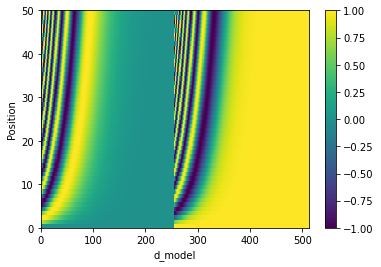

In [143]:
plt.pcolormesh(pos_encoding[0])
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [144]:
## Encoder 本人
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model 
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        ## num of layer

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        input_seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) ## scaling
        x += self.pos_encoding[:, :input_seq_len, :]
        x = self.dropout(x, training=training)
        
        ## go thorough those layer
        for i, enc_layer in enumerate(self.enc_layers):
            x = enc_layer(x, training, mask)

        return x 


In [145]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
 
    def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
        tar_seq_len = tf.shape(x)[1]
        attention_weights = {}  ## storing each encoder weights for analyze
    
    ## same as encoder
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :tar_seq_len, :]
        x = self.dropout(x, training=training)

        for i, dec_layer in enumerate(self.dec_layers):
              x, block1, block2 = dec_layer(x, enc_output, training,combined_mask, inp_padding_mask)
    
              attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
              attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights

In [146]:
## Finally! we made it
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, combined_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output) 
    
        return final_output, attention_weights

In [147]:
## try with our easy examples

num_layers = 1
d_model = 4
num_heads = 2
dff = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

## train to predict next word! as we say in seq2seq train
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
## combine them jiust choosing value 1 in tensor
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, output_vocab_size)

predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, combined_mask, inp_padding_mask)


In [148]:
print(tar)
print(tar_inp)
print(tar_real)
print()
print(predictions.shape) ## batch, length, prob of next single word

tf.Tensor(
[[4205   65    6    7  223 2078 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
tf.Tensor(
[[4205   65    6    7  223 2078 4206    0    0]
 [4205  165  489  398  191   14    7  560    3]], shape=(2, 9), dtype=int64)
tf.Tensor(
[[  65    6    7  223 2078 4206    0    0    0]
 [ 165  489  398  191   14    7  560    3 4206]], shape=(2, 9), dtype=int64)

(2, 9, 4207)


In [149]:
## what's our loss function???
## just like classication problem

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [150]:
## but our loss should not include
def loss_function(real, pred):
    ## inverse our mask
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    ## multiply it! we done!
    loss_ *= mask 
    return tf.reduce_mean(loss_)

In [151]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

<img src="lr-equation.jpg" width="70%">

In [152]:
## Our opt
## inside warm up steps  up up up
## outside smoothing decayed
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [153]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## TRAIN!

In [154]:
num_layers = 4 ## 先用 4 層,我電腦會爆掉
d_model = 128
num_heads = 8
dff = 512

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers, d_model, num_heads, dff,input_vocab_size, target_vocab_size, dropout_rate)

In [155]:
### all the mask create

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [163]:
log_dir

'Trans/logs/4layers_128d_8heads_512dff_20train_perc/4layers_128d_8heads_512dff'

In [167]:
## save cktpts
train_perc = 20

run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)


ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

## only save the 5 closest ckpt!
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint: ## if ckpt exists, dont train
    ckpt.restore(ckpt_manager.latest_checkpoint)
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print(f'latest checkpoin in {last_epoch} epochs')
else:
    last_epoch = 0
    print("train form scratch")

train form scratch


In [168]:

### path is wrong
ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint: ## if ckpt exists, dont train
    ckpt.restore(ckpt_manager.latest_checkpoint)
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print(f'latest checkpoin in {last_epoch} epochs')

In [169]:
@tf.function 
def train_step(inp, tar):

    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    ## creating masks
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)

        loss = loss_function(tar_real, predictions)

 
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
      

In [170]:
EPOCHS = 40
print(f"already train {last_epoch} epochs。")
print(f"last epochs：{min(0, last_epoch - EPOCHS)}")

for epoch in range(last_epoch, EPOCHS):
    start = time.time()
  
    for (step_idx, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)  

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

already train 0 epochs。
last epochs：-40
Saving checkpoint for epoch 1 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_perc/1layers_4d_2heads_8dff/4layers_128d_8heads_512dff/ckpt-1
Saving checkpoint for epoch 2 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_perc/1layers_4d_2heads_8dff/4layers_128d_8heads_512dff/ckpt-2
Saving checkpoint for epoch 3 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_perc/1layers_4d_2heads_8dff/4layers_128d_8heads_512dff/ckpt-3
Saving checkpoint for epoch 4 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_perc/1layers_4d_2heads_8dff/4layers_128d_8heads_512dff/ckpt-4
Saving checkpoint for epoch 5 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_perc/1layers_4d_2heads_8dff/4layers_128d_8heads_512dff/ckpt-5
Saving checkpoint for epoch 6 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_perc/1layers_4d_2heads_8dff/4layers_128d_8heads_512dff/ckpt-6
Saving checkpoint for epoch 7 at ./Trans/checkpoints/1layers_4d_2heads_8dff_20train_

In [171]:
def evaluate(inp_sentence):
    start_token = [subword_encoder_en.vocab_size]
    end_token = [subword_encoder_en.vocab_size + 1]
  
    inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
  

    decoder_input = [subword_encoder_zh.vocab_size]
    output = tf.expand_dims(decoder_input, 0)  ## for batch dim
  

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
    ## predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
        predictions = predictions[: , -1:, :]  
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    

        if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights
        ## adding the last step output
        output = tf.concat([output, predicted_id], axis=-1)

  
    return tf.squeeze(output, axis=0), attention_weights

In [293]:
sentence = "China, India, and others have enjoyed continuing economic growth."

predicted_seq, _ = evaluate(sentence)

target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

In [294]:
print(predicted_sentence)

印度和中国也是其他国家中国家中的经济增长。
